In [1]:
import os,sys
import ROOT
import json
import logging
from array import array
sys.path.append('..')
import tdr as tdrStyle
from lumi import CMS_lumi
from ratio import createRatio

Welcome to JupyROOT 6.22/06


INFO:root:VG not included in CR1
INFO:root:VG not included in CR2
INFO:root:VG not included in CR3
INFO:root:VG not included in SR
INFO:root:FakePho not included in CR1
INFO:root:FakePho not included in CR2
INFO:root:data not included in CR3
INFO:root:data not included in CR3
INFO:root:data not included in CR3
INFO:root:data not included in CR3
INFO:root:data not included in CR3
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Divide>: Dividing histograms with different labels
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


59.7 fb^{-1} (13 TeV)


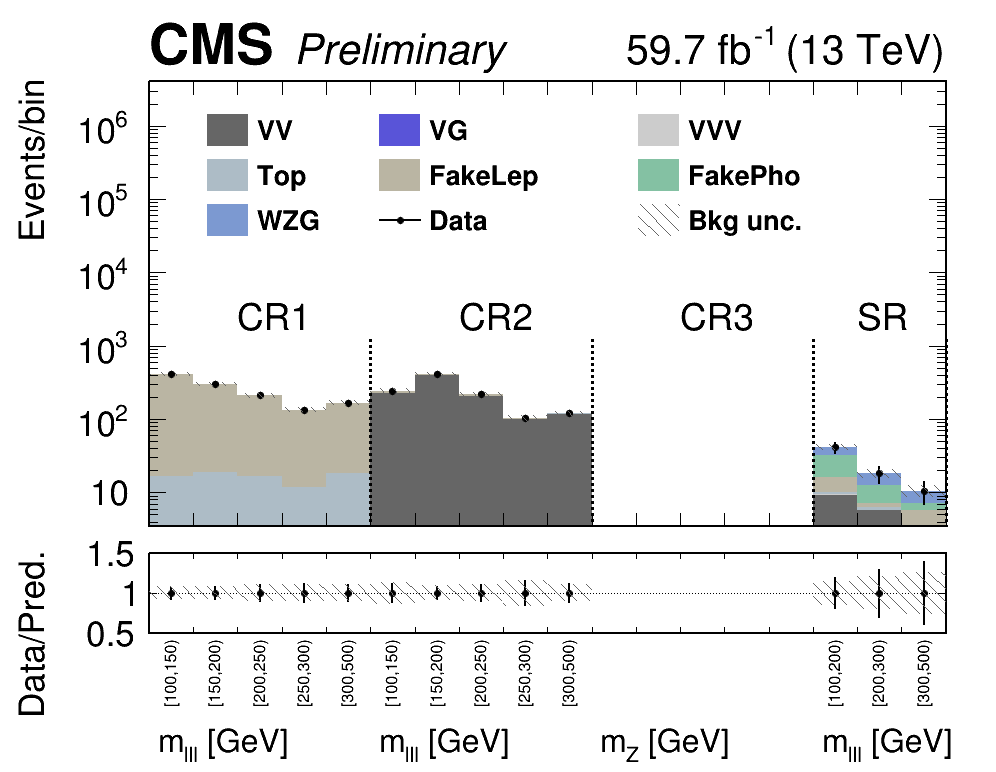

In [25]:
logging.basicConfig(level=logging.DEBUG)

def checkfile(file):
    if not os.path.isfile(file):
        raise Exception('{file} not existed'.format(file=file))

def sethiststyle(hist, color, Xtitle=' ', Ytitle=' ', ratio=1):
    if color != 1:
        hist.SetFillColor(color)
        hist.SetLineColor(0)
        hist.SetLineWidth(0)
    else:
        hist.SetLineWidth(2)
        hist.SetLineColor(1)
    hist.SetMarkerStyle(20)
    hist.SetMarkerColor(1)
    hist.SetYTitle('Events/bin')
    hist.SetStats(0)
#     hist.Sumw2()

    # Adjust y-axis settings
    # hist.GetYaxis().SetNdivisions(105)
    hist.GetYaxis().SetTitleSize(38)
    hist.GetYaxis().SetTitleFont(43)
    hist.GetYaxis().SetTitleOffset(1.50)
    hist.GetYaxis().SetLabelFont(43)
    hist.GetYaxis().SetLabelSize(38)
    hist.GetYaxis().SetLabelOffset(0.015)

    # Adjust x-axis settings
    hist.SetXTitle(str(Xtitle))
#     hist.GetXaxis().SetTitleSize(38)
    hist.GetXaxis().SetTitleSize(0)
    hist.GetXaxis().SetTitleFont(43)
    hist.GetXaxis().SetTitleOffset(6.2)
    hist.GetXaxis().SetLabelFont(43)
    hist.GetXaxis().SetLabelSize(18)
    hist.GetXaxis().SetLabelOffset(0.015)
    
tdrStyle.setTDRStyle()
tdrStyle.gtdr()

final_hists = {
    'VV':{
        'name':'VV',
        'color':13,
    },
    'VG':{
        'name':'VG',
        'color':9,
    },
    'VVV':{
        'name':'VVV',
        'color':17,
    },
    'Top':{
        'name':'Top',
        'color':33,
    },
    'FakeLep':{
        'name':'FakeLep',
        'color':23,
    },
    'FakePho':{
        'name':'FakePho',
        'color':30,
    },
    'WZG':{
        'name':'WZG',
        'color':38
    }
}

checkfile('combine.json')
checkfile('fitDiagnosticsTest.root')
Xtitle='m_{lll} [GeV]'

with open('combine.json') as f:
    jsons = json.load(f)
    f.close()
    
total_bin = 0
for region in jsons['regions']:
    region = jsons['regions'][region]
    bin_array = region['bin_array']
    total_bin += len(bin_array) - 1

file = ROOT.TFile('fitDiagnosticsTest.root','OPEN')


# Create stack for global plot
h_stack = ROOT.THStack("","")
h_mc = ROOT.TH1D("", "", total_bin, 0, total_bin)
h_mc.SetFillColor(ROOT.kGray+2)
h_mc.SetFillStyle(3345)
h_mc.SetMarkerSize(0.)
h_mc.SetMarkerColor(ROOT.kGray+2)
h_mc.SetLineWidth(0)
h_data = ROOT.TH1D("", "", total_bin, 0, total_bin)
sethiststyle(h_data, 1, ratio=0.7, Xtitle=Xtitle)
# Create line for global plot
lines = []
# Create text for global plot
texts = []
titles = []


# Create Legend for global plot
legend = ROOT.TLegend(0.20, 0.55, 0.90, 0.80)
legend.SetNColumns(3)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.SetTextSize(0.055)
legend.SetLineWidth(1)
legend.SetLineStyle(0)


# Create hist for each process
for process in final_hists:
    hist_temp = ROOT.TH1D("", "", total_bin, 0, total_bin)
    process = final_hists[process]
    process_name = process['name']
    
    global_bin_count = 1
    # Load every region
    for region in jsons['regions']:
        region = jsons['regions'][region]
        region_name = region['final_name']
        variable = region['variable_storename']
        tag = region['tag']
        bin_array = region['bin_array']
        if not process_name in region['processes']:
            logging.info("{process} not included in {region}".format(process=process['name'], region=region['final_name']))
            global_bin_count += len(bin_array) - 1
            continue
        
        # Load every bin
        for bin in range(1, len(bin_array)):
            branch_name = '{region_name}_{variable}_bin{bin}_{tag}'.format(region_name=region_name, variable=variable, bin=str(bin), tag=tag)
            branch = file.shapes_prefit.Get(branch_name)
            if hasattr(branch, process_name):
                bin_content = branch.Get(process_name).GetBinContent(1)
                bin_error = branch.Get(process_name).GetBinError(1)
#                 print(bin_content, bin_error)
                hist_temp.SetBinContent(global_bin_count, bin_content)
                hist_temp.SetBinError(global_bin_count, bin_error)
            else:
                logging.warning(process_name + ' not exist in ' + branch_name)
                pass
            global_bin_count += 1
            
    sethiststyle(hist_temp, process['color'], ratio=0.7)
    legend.AddEntry(hist_temp, process['name'], 'F')
    h_stack.Add(hist_temp)
    h_mc.Add(hist_temp)
    
    
# get data (asimov when blinded)
global_bin_count = 1
# Load every region
for region in jsons['regions']:
    region = jsons['regions'][region]
    region_name = region['final_name']
    variable = region['variable_storename']
    variable_plotname = region['variable_plotname']
    tag = region['tag']
    bin_array = region['bin_array']

    # Load every bin
    for bin in range(1, len(bin_array)):
        branch_name = '{region_name}_{variable}_bin{bin}_{tag}'.format(region_name=region_name, variable=variable, bin=str(bin), tag=tag)
        if not hasattr(file.shapes_prefit, branch_name):
            logging.info("data not included in {region}".format(process=process['name'], region=region['final_name']))
            global_bin_count += 1
            continue
            
        branch = file.shapes_prefit.Get(branch_name)
        bin_content = branch.Get('data').GetPointY(0)
        bin_error = branch.Get('data').GetErrorY(0)
#             bin_content = branch.Get('total').GetBinContent(1)
#             bin_error = branch.Get('total').GetBinError(1)
        h_data.SetBinContent(global_bin_count, bin_content)
        h_data.SetBinError(global_bin_count, bin_error)
        h_data.GetXaxis().SetBinLabel(global_bin_count, '[{left},{right})'.format(left=bin_array[bin-1], right=bin_array[bin]))
        h_data.GetXaxis().LabelsOption('v')
        global_bin_count += 1
        
    line_temp = ROOT.TLine(global_bin_count-1, 0, global_bin_count-1, 3.0*h_data.GetMaximum())
    line_temp.SetLineWidth(3)
    line_temp.SetLineColor(1)
    line_temp.SetLineStyle(2)
    lines.append(line_temp)
    
    text_temp = ROOT.TText(global_bin_count-1-len(bin_array)/2, 4.0*h_data.GetMaximum(), region_name)
    text_temp.SetTextSize(40)
    text_temp.SetTextFont(43)
    texts.append(text_temp)
    
    title_temp = ROOT.TLatex(global_bin_count-len(bin_array)+0.2, -1, variable_plotname)
    title_temp.SetTextSize(35)
    title_temp.SetTextFont(43)
    titles.append(title_temp)
    
    
# Initial Canvas
c1 = ROOT.TCanvas("","",1000,800)
c1.Draw()
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.30, 1, 1.00)
pad1.SetTopMargin(0.15)  # joins upper and lower plot
pad1.SetBottomMargin(0.025)  # joins upper and lower plot
pad1.SetLogy()
# pad1.SetGridx()
pad1.Draw()
# Lower ratio plot is pad2
c1.cd()  # returns to main canvas before defining pad2
pad2 = ROOT.TPad("pad2", "pad2", 0, 0.00, 1, 0.30)
pad2.SetTopMargin(0.055)  # joins upper and lower plot
pad2.SetBottomMargin(0.60)  # joins upper and lower plot
pad2.SetGridy()
pad2.Draw()

# Draw Everything
pad1.cd()
h_data.Draw('E0X0p')
h_data.SetMaximum(10000*h_data.GetMaximum())
h_stack.Draw('HIST SAME')
h_data.Draw('E0X0p SAME')
h_mc.Draw('e2 SAME')
legend.AddEntry(h_data, 'Data')
legend.AddEntry(h_mc, 'Bkg unc.', 'F')
legend.Draw('SAME')
for line in lines:
    line.Draw('SAME')
for text in texts:
    text.Draw('SAME')

h3 = createRatio(h_data, h_mc)
pad2.cd()
sethiststyle(h3, 1, ratio=0.28, Xtitle=Xtitle)
h3.SetYTitle('Data/Pred.')
h4 = createRatio(h_mc, h_mc)
sethiststyle(h4, 1, ratio=0.28, Xtitle=Xtitle)
h3.Draw('E0X0p')
h4.Draw('e2 SAME')
for title in titles:
    title.Draw("SAME")

CMS_lumi(pad1, 0, 0, lumi_sqrtS='59.7 fb^{-1} (13 TeV)')
ROOT.gPad.RedrawAxis()
ROOT.gStyle.SetPadLeftMargin(0.15)
ROOT.gStyle.SetPadBottomMargin(0.50)


# Create temp hist for each process for final plot